# Try PoPS in Jupyter Notebook

[r.pops.spread](https://grass.osgeo.org/grass7/manuals/addons/r.pops.spread.html) is a model for stochastic landscape spread of the pest and pathogens. It uses PoPS (Pest or Pathogen Spread) library. In this tutorial we will use it specifically to model the spread of Sudden Oak Death tree disease in the Rouge River-Siskiyou National Forest region of western Oregon. This tutorial uses sample dataset with

* tanoak host layer (LEMMA data)
* digital elevation model (NED)
* orthophoto (NAIP)
* roads, streams (USGS)
* mapset containing weather coefficients


### Intro to Jupyter Notebook

This is a quick introduction into Jupyter Notebook.  Use Shift+Enter to execute cells.

In [1]:
a = 6
b = 7
c = a * b
print("Answer is", c)

Python code can be mixed with command line code (Bash).
It is enough just to prefix the command line with an exclamation mark:

In [2]:
!echo "Answer is $c"

Answer is 42


### Setting up GRASS GIS session


In [1]:
from IPython.display import Image
from helper import initialize_GRASS_notebook

initialize_GRASS_notebook(binary="grass",
                          grassdata="data/grassdata", location="PoPS_SOD_tutorial",
                          mapset="tutorial")

import grass.script as gs
from helper import show_interactively, show

## Simulation

### Study area and preparation

First, we will set computational region of our analyses to predefined study area:


In [4]:
gs.run_command('g.region', region='small_study_area', flags='p')

We use already prepared weather coefficients, represented by raster layers per each week of a simulation.
With that, we need to prepare a text file. List and write the maps in a file using g.list:

In [5]:
gs.run_command('g.list', type='raster', pattern="average_weather_*", mapset='weather', output='weather.txt')

Let's look at initial infected tanoak trees in 2019.

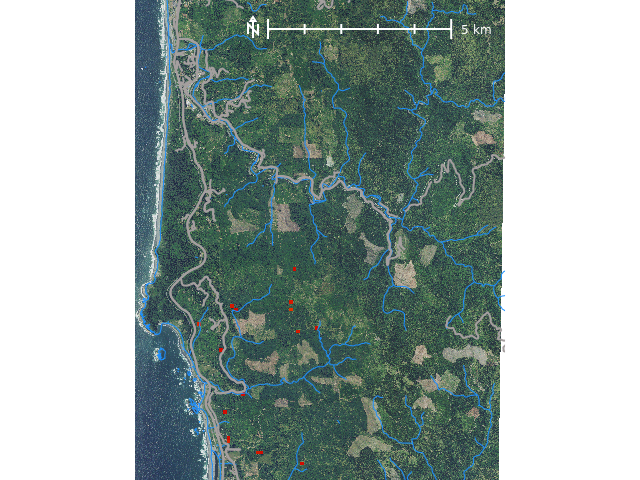

In [6]:
show('eu_infection_2019')

In [7]:
show_interactively('eu_infection_2019')

### Single stochastic run

Run the model using the text file created and setting the required parameters. For this analysis we used wind in NE  direction and are looking at the first 5 years of spread from the initial 2019 infection discovery.

We export a result from a single stochastic simulation (with specified random seed).

In [8]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential', natural_distance=242, natural_direction_strength=3,
               single_series='spread_sod', runs=1, random_seed=1)

We list newly created output layers representing infected trees in yeach year of the simulation and we set a custom color ramp.

In [9]:
series = gs.list_strings(type='raster', pattern="spread_sod*")
gs.run_command('r.colors', map=series, rules='color_infected.txt')
series

['spread_sod_2019_12_31@tutorial',
 'spread_sod_2020_12_31@tutorial',
 'spread_sod_2021_12_31@tutorial',
 'spread_sod_2022_12_31@tutorial',
 'spread_sod_2023_12_31@tutorial']

By changing the index from 0 to 4 you can display the steps of the simulation. Notice the NE direction of spread.

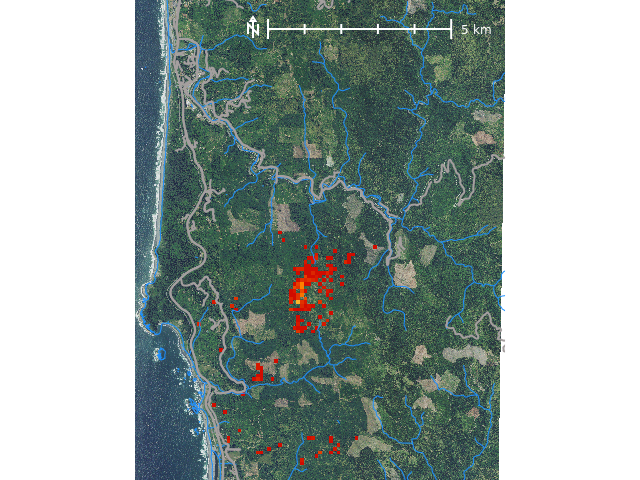

In [10]:
show(series[2])

### Multiple stochastic runs

We can run multiple stochastic runs and aggregate the results into a probability layer (0.1 if cell was infected once in 10 runs), average layer (average number of infected trees per cell) and standard deviation layer.

Here we run the process 10x and we use 2 cores for parallel processing (providing module was compiled with OpenMP support and cores are available).

In [11]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential', natural_distance=242, natural_direction_strength=3,
               average_series='average', probability_series='probability', stddev_series='stddev',
               runs=10, nprocs=2, random_seed=1)

Let's display the probability of infection at the end of 2019.

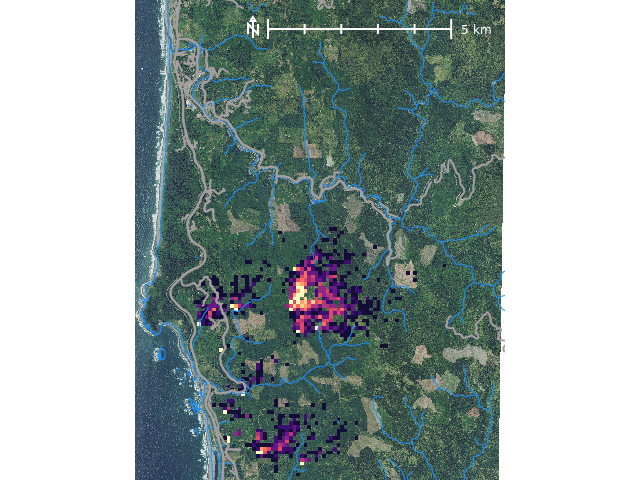

In [12]:
probability_series = gs.list_strings(type='raster', pattern="probability*")
gs.run_command('r.colors', map=probability_series, color='magma')
show(probability_series[2])

### Effect of dispersal kernel

The choice and parametrization of dispersal kernel significantly influences the spread and should be informed by calibration. The natural dispersal kernel (required) typically represents wind dispersal, additionally, we can optionally add the anthropogenic kernel which represents more human affected spread possibly over longer distances.

Each kernel is defined by type (cauchy, exponential), direction (none, N, NE, E, ...), direction strength (concentration around the direction using von mises distribution) and scale (distance).


In [13]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=400, natural_direction_strength=3,
               single_series='spread_distance', runs=1, random_seed=1)
distance_series = gs.list_strings(type='raster', pattern="spread_distance*")
gs.run_command('r.colors', map=distance_series, rules='color_infected.txt')

Compare our initial run with run with increased kernel scale

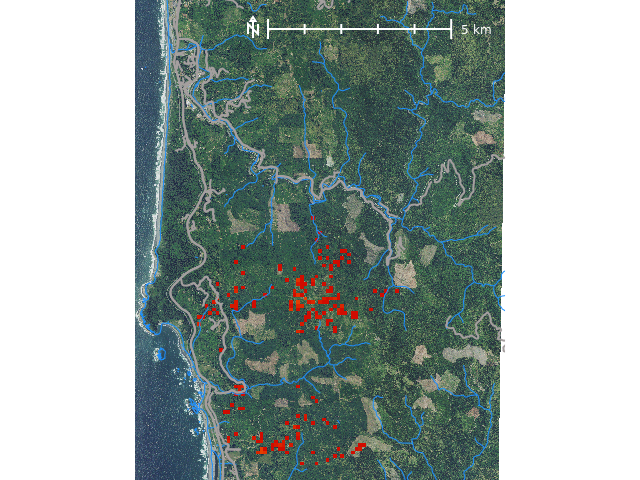

In [14]:
#show(series[2])
show(distance_series[2])

We can then also change the direction to E and increase the strength of direction:

In [15]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='E', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=10,
               single_series='spread_direction', runs=1, random_seed=1)
direction_series = gs.list_strings(type='raster', pattern="spread_direction*")
gs.run_command('r.colors', map=direction_series, rules='color_infected.txt')

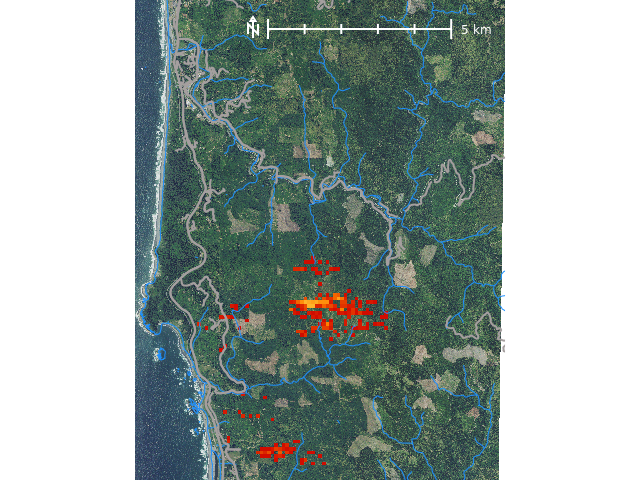

In [16]:
# show(series[2])
show(direction_series[2])

Finally, we can select a different kernel type.

In [17]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='cauchy',
               natural_distance=242, natural_direction_strength=3,
               single_series='spread_type', runs=1, random_seed=1)
disptype_series = gs.list_strings(type='raster', pattern="spread_type*")
gs.run_command('r.colors', map=disptype_series, rules='color_infected.txt')

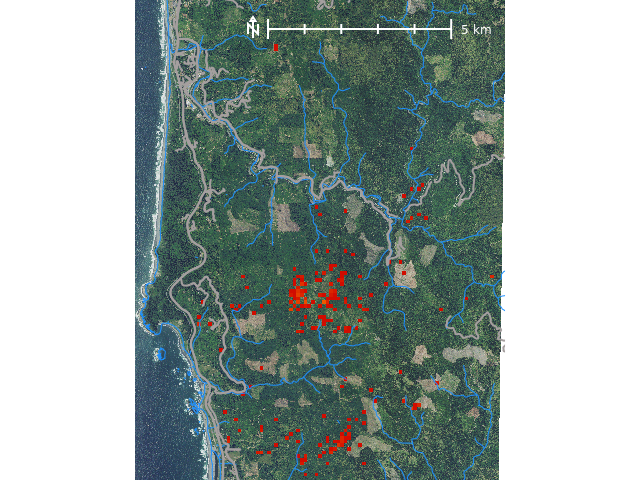

In [18]:
# show(series[2])
show(disptype_series[2])

### Effect of reproductive rate

Similarly to kernel, reproductive rate should be informed by calibration. In this example we double it:

In [19]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=3,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=3,
               single_series='spread_rate', runs=1, random_seed=1)
rate_series = gs.list_strings(type='raster', pattern="spread_rate*")
gs.run_command('r.colors', map=rate_series, rules='color_infected.txt')

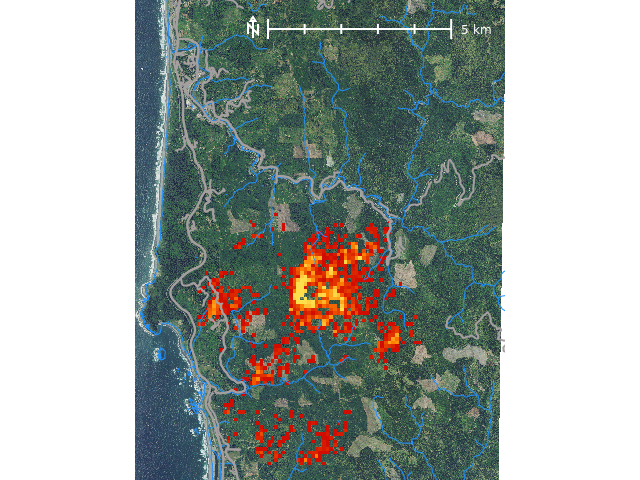

In [20]:
# show(series[2])
show(rate_series[2])

### Treatments

We will treat the area by removing the host. We will develop several scenarios. First, no treatment is applied:

In [26]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=3,
               probability_series='probability', runs=10, nprocs=2, random_seed=1)
probability_series = gs.list_strings(type='raster', pattern="probability*")
gs.run_command('r.colors', map=probability_series, color='magma')

We treat the initial infection and a buffer around it. The treatments are applied at the end of the year.

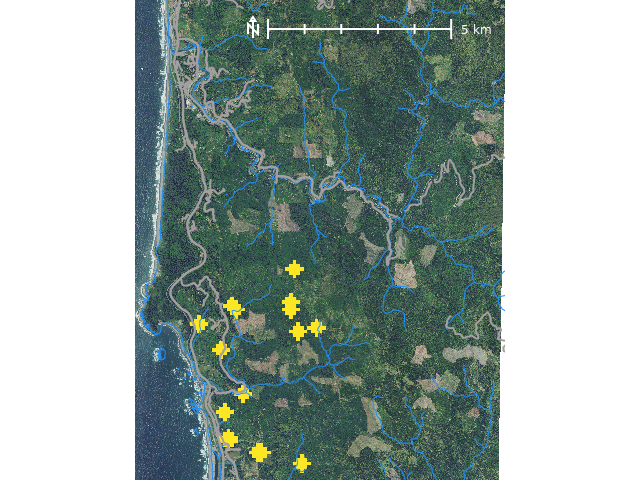

In [27]:
gs.run_command('r.buffer', flags='z', input='eu_infection_2019', output='buffer_A', distances=200)
gs.mapcalc("treatment_A = if (isnull(buffer_A), 0, 1)")
show('treatment_A')

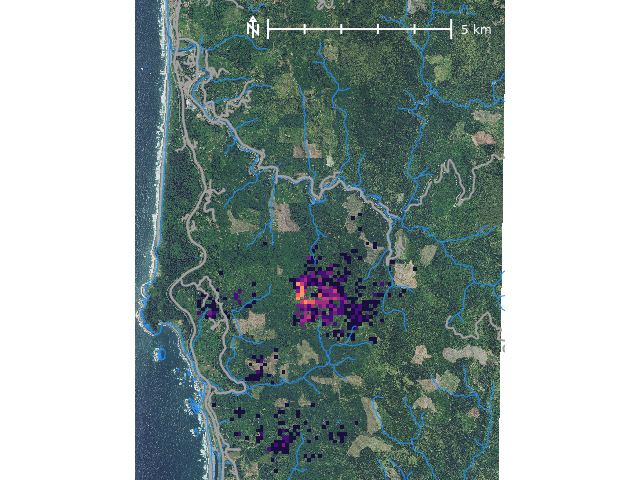

In [5]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=3,
               probability_series='probtreatmentA', runs=10, nprocs=2, random_seed=1,
               treatments='treatment_A', treatment_date='2019-12-01', treatment_length=0, treatment_application='ratio_to_all')
probabilityA_series = gs.list_strings(type='raster', pattern="probtreatmentA*")
gs.run_command('r.colors', map=probabilityA_series, color='magma')
show(probabilityA_series[2])

Here we increase the buffer size:

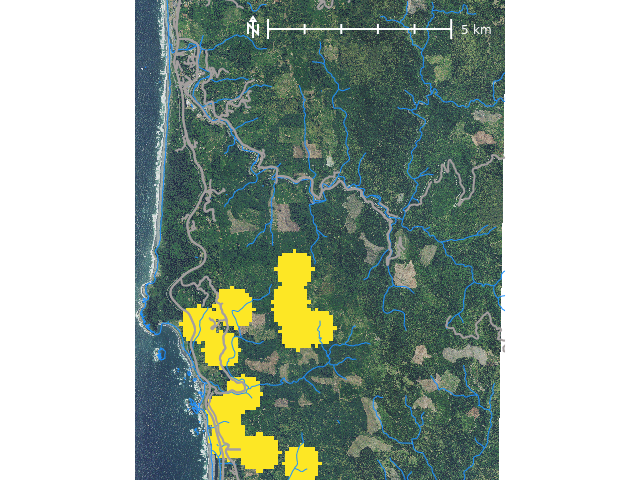

In [6]:
gs.run_command('r.buffer', flags='z', input='eu_infection_2019', output='buffer_B', distances=500)
gs.mapcalc("treatment_B = if (isnull(buffer_B), 0, 1)")
show('treatment_B')

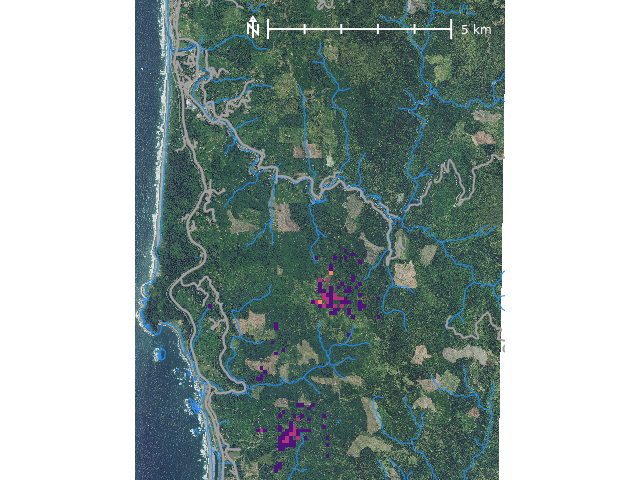

In [7]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=3,
               probability_series='probtreatmentB', runs=10, nprocs=2, random_seed=1,
               treatments='treatment_B', treatment_date='2019-12-01', treatment_length=0, treatment_application='ratio_to_all')
probabilityB_series = gs.list_strings(type='raster', pattern="probtreatmentB*")
gs.run_command('r.colors', map=probabilityB_series, color='magma')
show(probabilityB_series[2])

Now we create a large 1km wide barrier in an attempt to stop the spread. For this scenario, we assume the treatment is not 100% effective, but rather only 75% of host is removed.

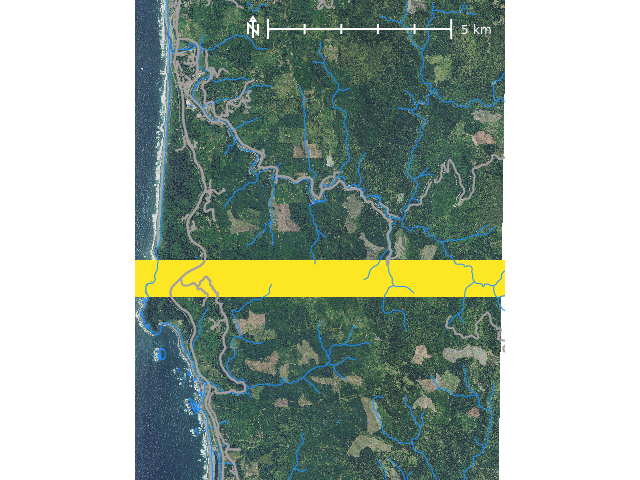

In [26]:
gs.mapcalc("treatment_C = if (y() > 4687000 && y() < 4688000, 0.75, 0 )")
show('treatment_C')

We will see that for the final year of our simulation, the disease spread in several stochastic runs over the barrier:

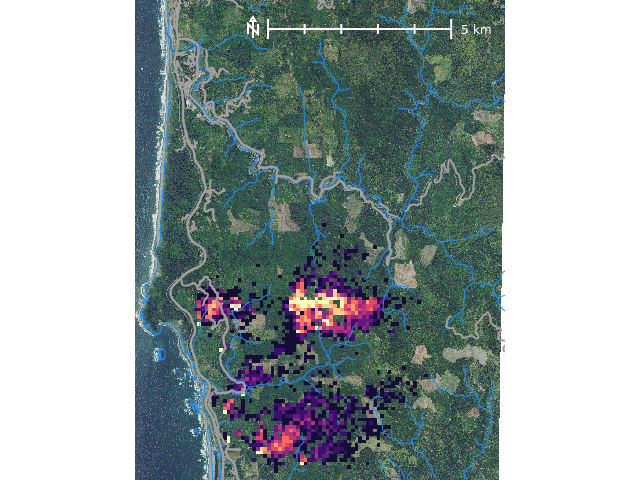

In [27]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=3,
               probability_series='probtreatmentC', runs=10, nprocs=2, random_seed=1,
               treatments='treatment_C', treatment_date='2019-12-01', treatment_length=0,
               treatment_application='ratio_to_all')
probabilityC_series = gs.list_strings(type='raster', pattern="probtreatmentC*")
gs.run_command('r.colors', map=probabilityC_series, color='magma')
show(probabilityC_series[4])

Finally, we manage with the 200m buffer treatments A in 2019 and with the barrier in 2021:

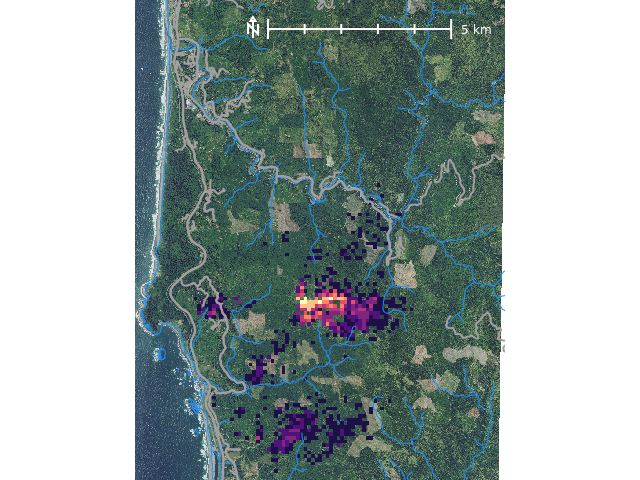

In [33]:
gs.run_command('r.pops.spread', host='host', total_plants='max_host', infected='eu_infection_2019',
               start_time=2019, end_time=2023, step='week', weather_coefficient_file='weather.txt',
               reproductive_rate=1.6,
               natural_direction='NE', natural_dispersal_kernel='exponential',
               natural_distance=242, natural_direction_strength=3,
               probability_series='probtreatmentAC', runs=10, nprocs=2, random_seed=1,
               treatments='treatment_A,treatment_C,', treatment_date='2019-12-01,2021-12-01',
               treatment_length=[0,0], treatment_application='ratio_to_all')
probabilityAC_series = gs.list_strings(type='raster', pattern="probtreatmentAC*")
gs.run_command('r.colors', map=probabilityAC_series, color='magma')
show(probabilityAC_series[4])